In [1]:
# FOR GOOGLE COLAB ENVIRONMENT ONLY
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
import tensorflow as tf
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-11-20 13:35:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-20 13:35:49 (123 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
dir_path = './drive/MyDrive/Datathon/'
df = pd.read_csv(dir_path + 'train_labels.csv', names=["path", "label"], dtype=str)

dir_path = './drive/MyDrive/Datathon/train_imgs/train_imgs/'
df = df.sample(frac=1).reset_index()

df.head()

,index,path,label
0,1726,3626.jpg,0
1,391,552.jpg,1
2,2208,5221.jpg,0
3,2416,1423.jpg,0
4,1354,2684.jpg,1


# Model

In [5]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

# Image generator

In [6]:
generator = ImageDataGenerator(
    rotation_range= 40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1./255,
    validation_split=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
train_gen = generator.flow_from_dataframe(df, directory=dir_path, x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df, directory=dir_path, x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 1834 validated image filenames belonging to 2 classes.
Found 785 validated image filenames belonging to 2 classes.


In [8]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: '0', 1: '1'}


# Model training

In [9]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [13]:
history = model.fit(x=train_gen,batch_size=32,epochs=30,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/30
58/58 [==============================] - 638s 11s/step - loss: 0.5127 - accuracy: 0.7454 - recall: 0.8093 - auc: 0.8205 - val_loss: 0.3956 - val_accuracy: 0.8420 - val_recall: 0.8233 - val_auc: 0.9275 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - 59s 1s/step - loss: 0.2762 - accuracy: 0.8833 - recall: 0.8865 - auc: 0.9525 - val_loss: 0.2536 - val_accuracy: 0.9019 - val_recall: 0.8707 - val_auc: 0.9720 - lr: 0.0010
Epoch 3/30
58/58 [==============================] - 58s 1s/step - loss: 0.2341 - accuracy: 0.9024 - recall: 0.9092 - auc: 0.9649 - val_loss: 0.2098 - val_accuracy: 0.9236 - val_recall: 0.9375 - val_auc: 0.9727 - lr: 0.0010
Epoch 4/30
58/58 [==============================] - 59s 1s/step - loss: 0.1966 - accuracy: 0.9209 - recall: 0.9310 - auc: 0.9756 - val_loss: 0.2007 - val_accuracy: 0.9299 - val_recall: 0.9461 - val_auc: 0.9759 - lr: 0.0010
Epoch 5/30
58/58 [==============================] - 59s 1s/step - loss: 0.1861 - accuracy: 0.9291 - recall

# Testing

In [14]:
dir_path = './drive/MyDrive/Datathon/'
test_df = pd.read_csv(dir_path + 'test_labels.csv', names=["path", "label"], dtype=str)

dir_path = './drive/MyDrive/Datathon/test_imgs/test_imgs/'
test_df = test_df.sample(frac=1).reset_index()

test_df.head()

,index,path,label
0,162,390.jpg,1
1,296,738.jpg,1
2,310,768.jpg,1
3,34,66.jpg,0
4,54,115.jpg,0


In [15]:
test_gen = ImageDataGenerator()

In [16]:
test_dataset = test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=dir_path,
    x_col='path',
    y_col='label',
    target_size=(255, 255),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42 
)

Found 400 validated image filenames belonging to 2 classes.


# Evaluation

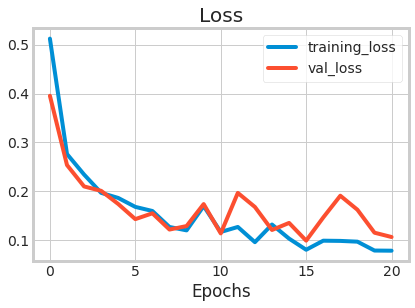

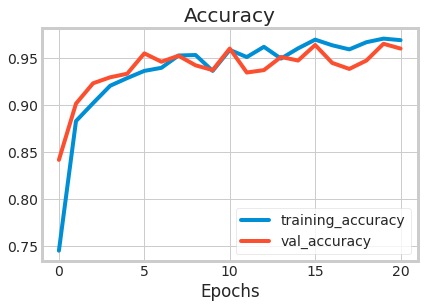

In [18]:
plot_loss_curves(history)

In [19]:
# Predict the label of the test_images
pred = []
from tensorflow.keras.preprocessing import image

for i, path, l in test_df.values:
  if path == '.DS_Store':
    continue
  print(dir_path + path)
  img = image.load_img(dir_path + path)
  img = image.img_to_array(img)/255
  img = tf.image.resize(img,(256,256))
  img = tf.expand_dims(img,axis=0)
  prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
  pred.append(prediction)


./drive/MyDrive/Datathon/test_imgs/test_imgs/390.jpg
1/1 [==============================] - 0s 213ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/738.jpg
1/1 [==============================] - 0s 19ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/768.jpg
1/1 [==============================] - 0s 15ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/66.jpg
1/1 [==============================] - 0s 17ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/115.jpg
1/1 [==============================] - 0s 15ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/298.jpg
1/1 [==============================] - 0s 17ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/570.jpg
1/1 [==============================] - 0s 16ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/26.jpg
1/1 [==============================] - 0s 18ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/683.jpg
1/1 [==============================] - 0s 16ms/step
./drive/MyDrive/Datathon/test_imgs/test_imgs/393.jpg
1/1

In [20]:
print(pred)

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 

Text(0.5, 1.0, 'True: 0\nPredicted: 0')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 0\nPredicted: 0')

Text(0.5, 1.0, 'True: 0\nPredicted: 0')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 0\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 0\nPredicted: 0')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 0')

Text(0.5, 1.0, 'True: 0\nPredicted: 0')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 0\nPredicted: 0')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

Text(0.5, 1.0, 'True: 1\nPredicted: 1')

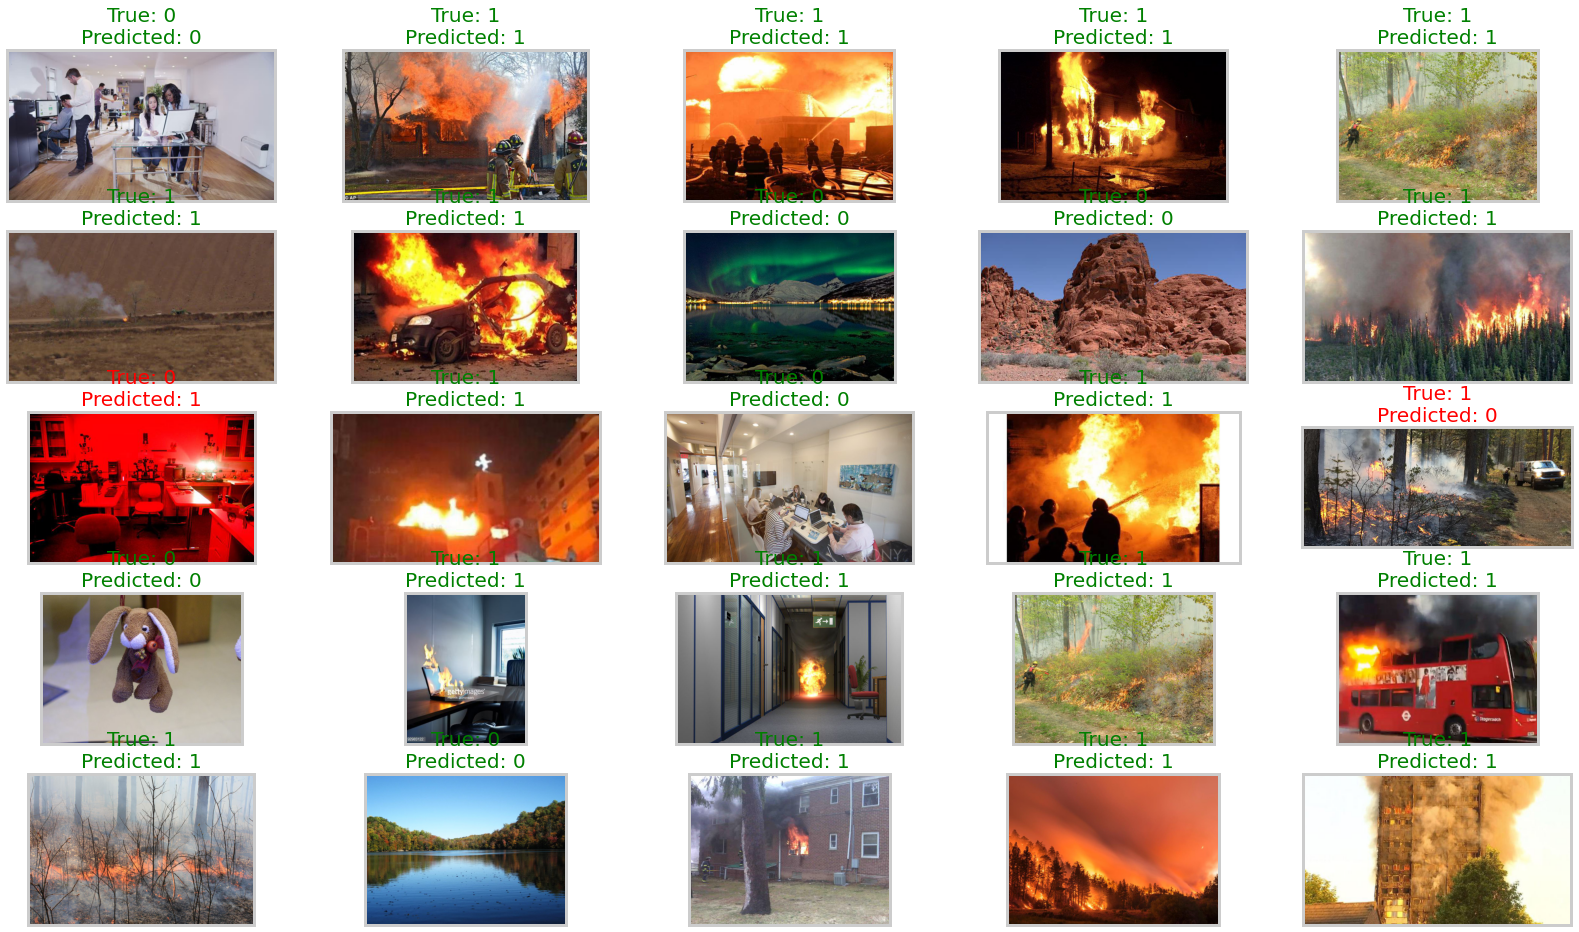

<Figure size 432x288 with 0 Axes>

In [21]:
from PIL import Image
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(dir_path+test_df.path.iloc[random_index[i]])
    ax.imshow(image)
    if int(test_df.label.iloc[random_index[i]]) == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [22]:
y_test = list(test_df.label)

y_test = [int(y) for y in y_test]

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       202
           1       0.89      0.97      0.93       198

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400



In [23]:
import seaborn as sns
classes = list(test_dataset.class_indices.keys())

# Function to print colorful confusion matrix
def color_confusion_matrix (cm):
    plt.figure(figsize = (5,5))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = classes, 
        yticklabels = classes)

In [24]:
import csv
from tensorflow.keras.preprocessing import image

file = open('test_labels_python.csv', 'w')

writer = csv.writer(file)

for path in os.listdir(dir_path):
  if path == '.DS_Store':
    continue
  data = [path]
  # print(dir_path + path)
  img = image.load_img(dir_path + path)
  img = image.img_to_array(img)/255
  img = tf.image.resize(img,(256,256))
  img = tf.expand_dims(img,axis=0)

  prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
  data.append(prediction)
  writer.writerow(data)

file.close()

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 37ms/step


11

1/1 [==============================] - 0s 28ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 23ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


10

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


10

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


10

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


9

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 15ms/step


9

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 21ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


10

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 19ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 22ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 14ms/step


10

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 21ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 21ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 26ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 14ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 23ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


10

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 21ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


10

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 23ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 21ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


9

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 21ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 26ms/step


10

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 14ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 16ms/step


10

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 20ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 18ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 17ms/step


11

1/1 [==============================] - 0s 19ms/step


11

1/1 [==============================] - 0s 17ms/step


10

1/1 [==============================] - 0s 16ms/step


11

1/1 [==============================] - 0s 15ms/step


11

1/1 [==============================] - 0s 15ms/step


10

1/1 [==============================] - 0s 15ms/step


11

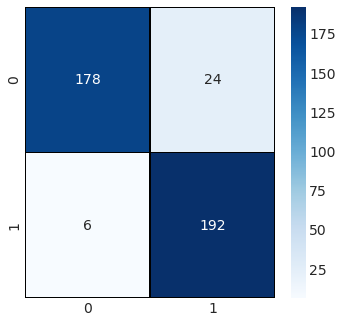

In [25]:
y_preds = pred

y_test = test_df.label
y_test = [int(y) for y in y_test]

conf_mat = confusion_matrix(y_test, y_preds)
color_confusion_matrix(conf_mat)

In [26]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(model, filename)

['finalized_model.sav']